<a href="https://colab.research.google.com/github/minjun1/GEE-lab6/blob/main/lab6_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sparsity promote interpolation for Irregular missing data with random noise

We are going to use Pytorch with GPU setup. 

In [11]:
!pip3 install torch==1.7.1 torchvision==0.8.2 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##### In this lab, we are going to solve both 2D interpolation and denoising simultaneously using different kinds of regularization terms. For example, we can use the L1 regularization term that can promote the sparsity in the FK domain. 

## Make a broadband plane wave example

In [24]:
!wget https://raw.githubusercontent.com/minjun1/GEE-lab6/main/planewave.py
!wget https://raw.githubusercontent.com/minjun1/GEE-lab6/main/utilities_mj.py
!wget -P models/ https://raw.githubusercontent.com/minjun1/GEE-lab6/main/models/skip.py
!wget -P models/ https://raw.githubusercontent.com/minjun1/GEE-lab6/main/models/common.py
!wget -P models/ https://raw.githubusercontent.com/minjun1/GEE-lab6/main/models/downsampler.py

--2023-03-10 00:25:15--  https://raw.githubusercontent.com/minjun1/GEE-lab6/main/planewave.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3390 (3.3K) [text/plain]
Saving to: ‘planewave.py.14’

planewave.py.14     100%[===================>]   3.31K  --.-KB/s    in 0s      

2023-03-10 00:25:15 (55.5 MB/s) - ‘planewave.py.14’ saved [3390/3390]

--2023-03-10 00:25:16--  https://raw.githubusercontent.com/minjun1/GEE-lab6/main/utilities_mj.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9456 (9.2K) [text/plain]
Saving to: ‘utili

In [12]:
import numpy as np
import planewave as pw
import scipy.ndimage as sciim
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator,AutoLocator
from utilities_mj import *

In [32]:
# Create the line
nt = 170; dt = 0.001
nx = 100;  dx = 5.0 
print("Tfinal=%f"%((nt-1)*dt))
t1 = 0.075
myline1 = pw.line(nx,dx,nt,dt,v=15000   ,t0=t1-0.025,sign=-1,kind='linear').T
myline2 = pw.line(nx,dx,nt,dt,v=17000   ,t0=t1+0.025,sign= 1,kind='linear').T
myline3 = pw.line(nx,dx,nt,dt,v=10000000,t0=t1      ,sign= 1,kind='linear').T


# Ricker wavelet parameters
ntw = 300; otw = 0.0; dtw = 0.001
amp = 0.5; dly = 0.125; f = 100.0; ns = int(dly/dtw)
wav = pw.ricker(nt,dt,f,amp,dly)

# Convolve with ricker
bb1 = np.array([np.convolve(myline1[ix,:],wav) for ix in range(nx)])[:,ns:nt+ns]
bb2 = np.array([np.convolve(myline2[ix,:],wav) for ix in range(nx)])[:,ns:nt+ns]
bb3 = np.array([np.convolve(myline3[ix,:],wav) for ix in range(nx)])[:,ns:nt+ns]
bb = bb1 + bb2 + bb3

# Compute 2D amplitude spectrum
print(bb.shape)
bbfft,w,kx = pw.fft2d(bb,dt,dx/1000.0)

Tfinal=0.169000
(100, 170)


In [33]:
data = np.zeros(shape=[1,170,100])
data[0,:,:] = bb.T
data = data/(np.max(data)*2)

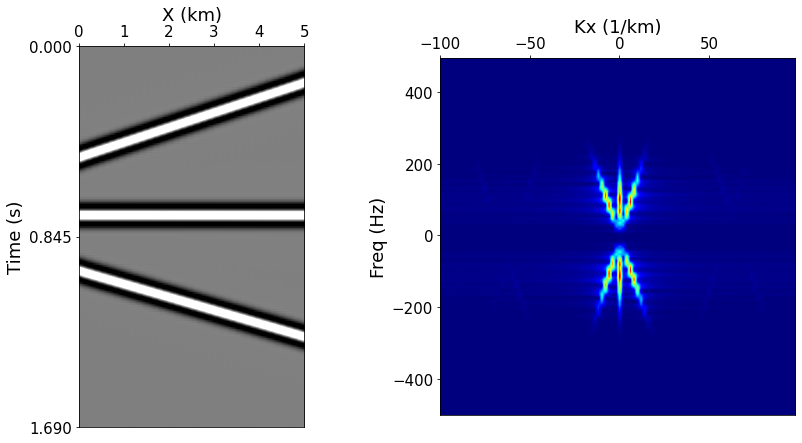

In [34]:
# Plot
datafft,w,kx = pw.fft2d(data[0,:,:].T,dt,dx/1000.0)

fig1,ax1 = plt.subplots(1,2,figsize=(14,7))
v=0.2
ax1[0].imshow(data[0,:,:],cmap='gray',extent=[0,nx*dx/100,((nt-1)*dt*10),0.0],aspect=5.0,
          vmin=-v,vmax=v,interpolation='sinc')
ax1[0].set_xlabel('X (km)',fontsize=18)
ax1[0].set_ylabel('Time (s)',fontsize=18)
ax1[0].tick_params(labelsize=15)
ax1[0].xaxis.tick_top()
ax1[0].xaxis.set_label_position('top') 
ax1[0].get_yaxis().set_major_locator(LinearLocator(numticks=3))
ax1[1].imshow(np.abs(datafft).T,cmap='jet',extent=[kx[0],kx[-1],w[0],w[-1]],aspect=0.2,interpolation='bilinear')
ax1[1].set_xlabel('Kx (1/km)',fontsize=18)
ax1[1].set_ylabel('Freq (Hz)',fontsize=18)
ax1[1].tick_params(labelsize=15)
ax1[1].xaxis.tick_top()
ax1[1].xaxis.set_label_position('top') 

plt.show()

## Apply a mask operator

In [35]:
# Function: Mask(input, percent of missing, reg=1 (irreg=0))

#apply the irregular mask
mask = Mask(data, 30, reg=0)
data_m = data[0,:,:]*mask[0,:,:]
outfft_m,w,kx = pw.fft2d(data_m.T,dt,dx/1000.0)

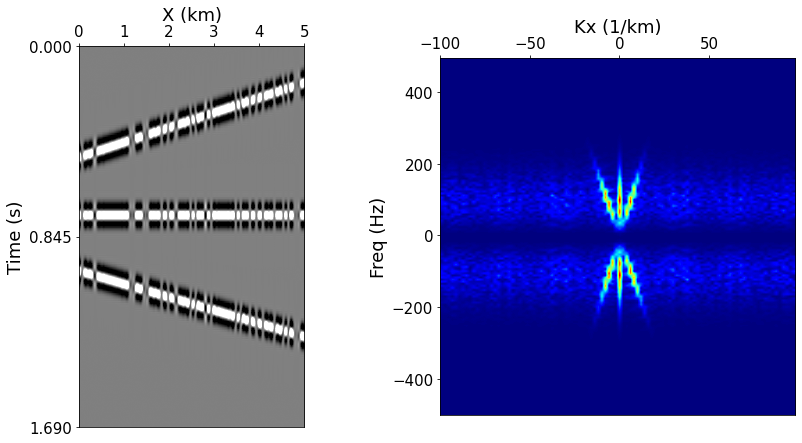

In [36]:
# Plot
data_m = data[0,:,:]*mask[0,:,:]

outfft_m,w,kx = pw.fft2d(data_m.T,dt,dx/1000.0)
fig1,ax1 = plt.subplots(1,2,figsize=(14,7))
v=0.2
ax1[0].imshow(data_m,cmap='gray',extent=[0,nx*dx/100,((nt-1)*dt*10),0.0],aspect=5.0,
          vmin=-v,vmax=v,interpolation='sinc')
ax1[0].set_xlabel('X (km)',fontsize=18)
ax1[0].set_ylabel('Time (s)',fontsize=18)
ax1[0].tick_params(labelsize=15)
ax1[0].xaxis.tick_top()
ax1[0].xaxis.set_label_position('top') 
ax1[0].get_yaxis().set_major_locator(LinearLocator(numticks=3))
ax1[1].imshow(np.abs(outfft_m).T,cmap='jet',extent=[kx[0],kx[-1],w[0],w[-1]],aspect=0.2,interpolation='bilinear')
ax1[1].set_xlabel('Kx (1/km)',fontsize=18)
ax1[1].set_ylabel('Freq (Hz)',fontsize=18)
ax1[1].tick_params(labelsize=15)
ax1[1].xaxis.tick_top()
ax1[1].xaxis.set_label_position('top') 

plt.show()

## Add a random noise

In [42]:
# # Plot
# data_n = data[0,:,:]*mask[0,:,:] + 0.1*np.random.randn(*data.shape)[0]
# data += 0.1*np.random.randn(*data.shape)[0]
# outfft_m,w,kx = pw.fft2d(data_n.T,dt,dx/1000.0)
# fig1,ax1 = plt.subplots(1,2,figsize=(14,7))
# v=0.2
# ax1[0].imshow(data_n,cmap='gray',extent=[0,nx*dx/100,((nt-1)*dt*10),0.0],aspect=5.0,
#           vmin=-v,vmax=v,interpolation='sinc')
# ax1[0].set_xlabel('X (km)',fontsize=18)
# ax1[0].set_ylabel('Time (s)',fontsize=18)
# ax1[0].tick_params(labelsize=15)
# ax1[0].xaxis.tick_top()
# ax1[0].xaxis.set_label_position('top') 
# ax1[0].get_yaxis().set_major_locator(LinearLocator(numticks=3))
# ax1[1].imshow(np.abs(outfft_m).T,cmap='jet',extent=[kx[0],kx[-1],w[0],w[-1]],aspect=0.2,interpolation='bilinear')
# ax1[1].set_xlabel('Kx (1/km)',fontsize=18)
# ax1[1].set_ylabel('Freq (Hz)',fontsize=18)
# ax1[1].tick_params(labelsize=15)
# ax1[1].xaxis.tick_top()
# ax1[1].xaxis.set_label_position('top') 

# plt.show()

In [49]:
from models.skip import skip
import torch
import torch.optim
# from utils.inpainting_utils import *
PLOT = True
imsize = -1
dim_div_by = 64
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'
INPUT = 'noise'
input_depth = 32
LR = 0.01 
num_iter = 6001
param_noise = False
show_every = 200
figsize = 5
reg_noise_std = 0.03
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

net = skip(input_depth, data.shape[0], 
            num_channels_down = [128] * 5,
            num_channels_up =   [128] * 5,
            num_channels_skip =    [32] * 5,  
            filter_size_up = 3, filter_size_down = 3, 
            upsample_mode='nearest', filter_skip_size=1,
            need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

In [50]:
net = net.type(dtype)
net_input = get_noise(input_depth, INPUT,(len(data[0,:,0]),len(data[0,0,:]))).type(dtype)

### Optimize

In [51]:
dtype = torch.cuda.FloatTensor
img_var = np_to_torch(data).type(dtype)
mask_var = np_to_torch(mask).type(dtype)
mse = torch.nn.MSELoss().type(dtype)

In [52]:
mod = img_var*mask_var

Starting optimization with ADAM


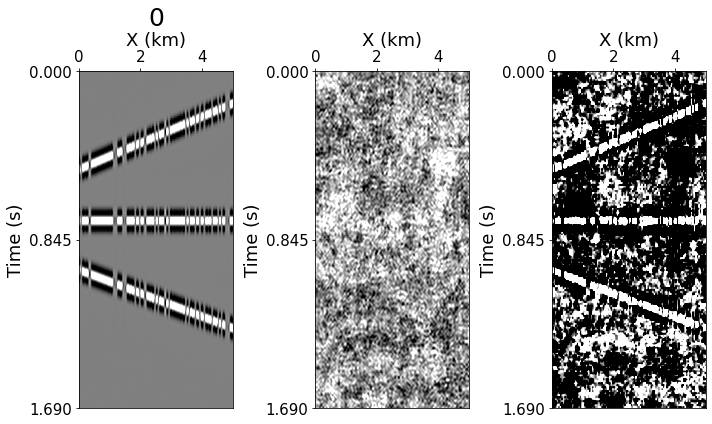

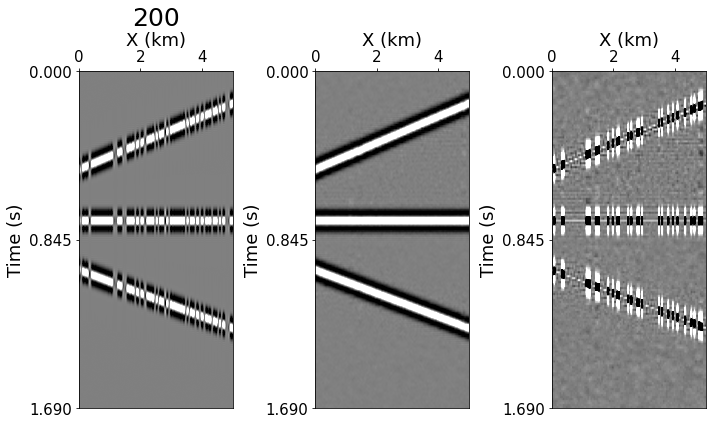

KeyboardInterrupt: ignored

In [54]:
i=0
dim=2
lamda = 0.1 # 0.0001
lamda2 = 0.1
def closure():
    global i
    global loss 
    global sigma_est
    global rsnr_trend
    torch.autograd.set_detect_anomaly(True)
    
    
    out = net(net_input) - 0.5  
    sparse = torch.rfft(out, dim, onesided=False).clone().type(dtype)
    total_loss =  mse(out * mask_var, img_var * mask_var)# + lamda*torch.abs(sparse).sum()
    total_loss.backward()
    
    out_np = torch_to_np(out) 
    print ('Iteration %05d    MSE true %f  ' % (i,  mse(mod* mask_var, img_var * mask_var).item()), '\r', end='')
    
    if  i % 200 == 0:
        fig, ax = plt.subplots(1,3,figsize=(10,6))
        v=0.2
        ax[0].imshow(mask[0,:,:]*data[0,:,:],cmap='gray',vmax=v,vmin=-v,aspect='auto',extent=[0,nx*dx/100,((nt-1)*dt*10),0.0],interpolation='sinc') 
        ax[0].set_xlabel('X (km)',fontsize=18)
        ax[0].set_ylabel('Time (s)',fontsize=18)
        ax[0].tick_params(labelsize=15)
        ax[0].xaxis.tick_top()
        ax[0].xaxis.set_label_position('top') 
        ax[0].get_yaxis().set_major_locator(LinearLocator(numticks=3))
        ax[0].set_title('%d'%i,fontsize=25)
        
        
        ax[1].imshow(out_np[0,:,:],cmap='gray',vmax=v,vmin=-v,aspect='auto',extent=[0,nx*dx/100,((nt-1)*dt*10),0.0],interpolation='sinc')
        ax[1].set_xlabel('X (km)',fontsize=18)
        ax[1].set_ylabel('Time (s)',fontsize=18)
        ax[1].tick_params(labelsize=15)
        ax[1].xaxis.tick_top()
        ax[1].xaxis.set_label_position('top') 
        ax[1].get_yaxis().set_major_locator(LinearLocator(numticks=3))
                
        ax[2].imshow(mask[0,:,:]*data[0,:,:]-out_np[0,:,:],cmap='gray',vmax=v/5,vmin=-v/5,aspect='auto',extent=[0,nx*dx/100,((nt-1)*dt*10),0.0]) 
        ax[2].set_xlabel('X (km)',fontsize=18)
        ax[2].set_ylabel('Time (s)',fontsize=18)
        ax[2].tick_params(labelsize=15)
        ax[2].xaxis.tick_top()
        ax[2].xaxis.set_label_position('top') 
        ax[2].get_yaxis().set_major_locator(LinearLocator(numticks=3))
        plt.tight_layout()
        plt.show()
    i += 1
    return total_loss

OPT_OVER = 'net'
OPTIMIZER = 'adam'
LR = 0.01 

p = get_params(OPT_OVER, net ,net_input)
optimize(OPTIMIZER, p, closure, LR, 3001)

Starting optimization with ADAM


<ipython-input-12-d8c751d71bf3>:11: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  sparse = torch.rfft(mod, dim, onesided=False).clone().type(dtype)


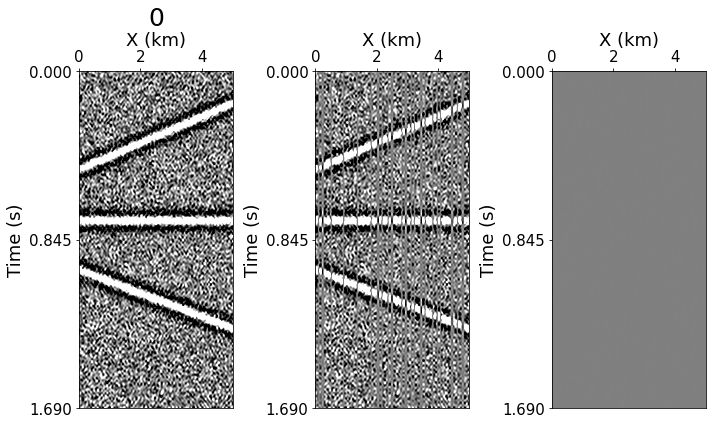

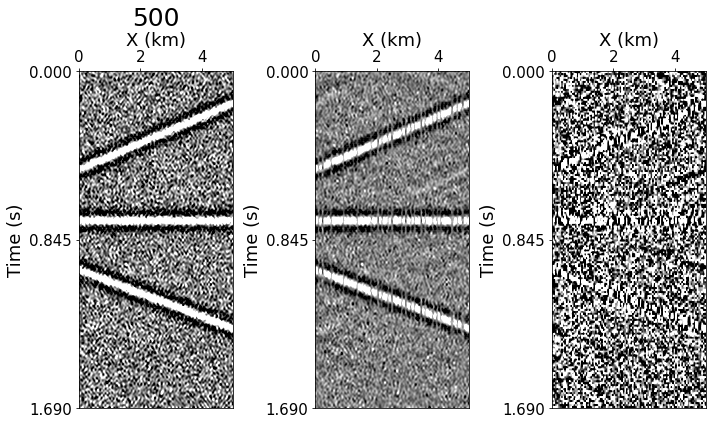

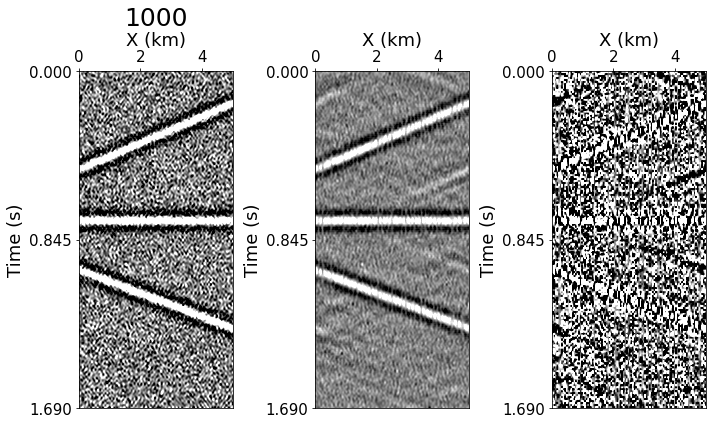

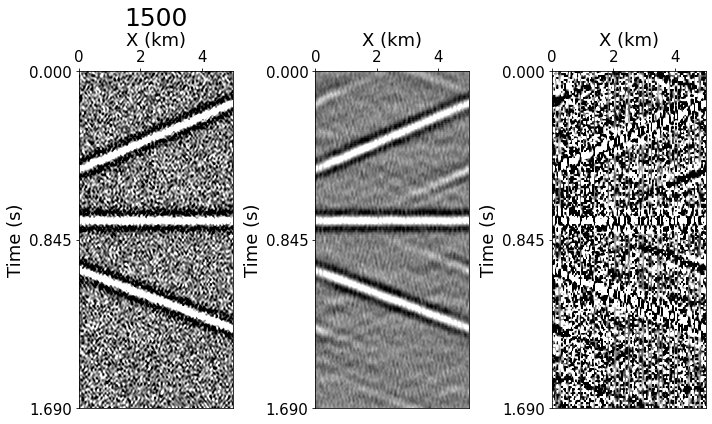

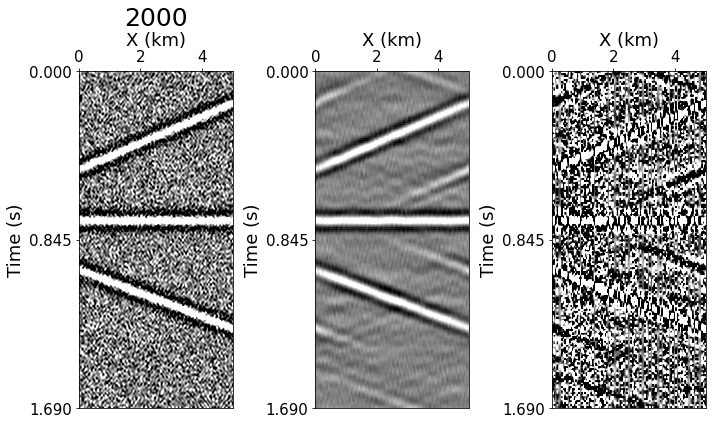

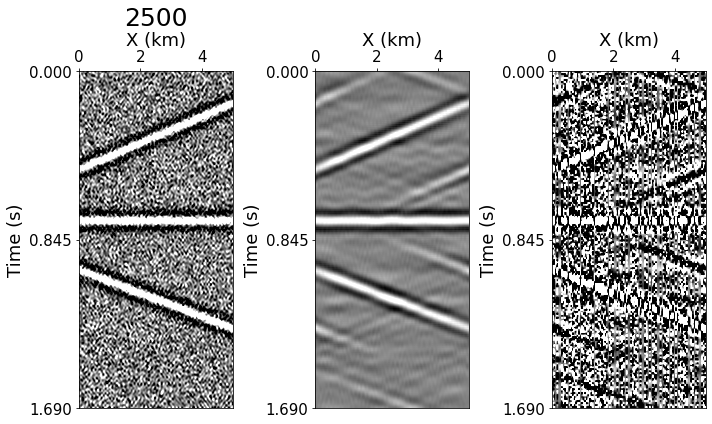

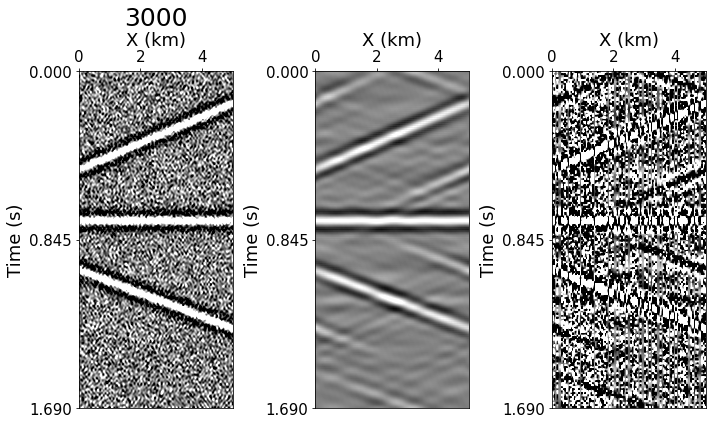

In [ ]:
i=0
dim=2
lamda = 0.1 # 0.0001
lamda2 = 0.1
def closure():
    global i
    global loss 
    global sigma_est
    global rsnr_trend
    torch.autograd.set_detect_anomaly(True)
    sparse = torch.rfft(mod, dim, onesided=False).clone().type(dtype)
    total_loss =  mse(mod* mask_var, img_var*mask_var) + lamda*torch.abs(sparse).sum()#+lamda2*torch.norm(mod)
    total_loss.backward()
    
    out_np = torch_to_np(mod) 
    print ('Iteration %05d    MSE true %f  ' % (i,  mse(mod* mask_var, img_var * mask_var).item()), '\r', end='')
    
    if  i % 500 == 0:
        fig, ax = plt.subplots(1,3,figsize=(10,6))
        v=0.2
        ax[0].imshow(data[0,:,:],cmap='gray',vmax=v,vmin=-v,aspect='auto',extent=[0,nx*dx/100,((nt-1)*dt*10),0.0],interpolation='sinc') 
        ax[0].set_xlabel('X (km)',fontsize=18)
        ax[0].set_ylabel('Time (s)',fontsize=18)
        ax[0].tick_params(labelsize=15)
        ax[0].xaxis.tick_top()
        ax[0].xaxis.set_label_position('top') 
        ax[0].get_yaxis().set_major_locator(LinearLocator(numticks=3))
        ax[0].set_title('%d'%i,fontsize=25)
        
        
        ax[1].imshow(out_np[0,:,:],cmap='gray',vmax=v,vmin=-v,aspect='auto',extent=[0,nx*dx/100,((nt-1)*dt*10),0.0],interpolation='sinc')
        ax[1].set_xlabel('X (km)',fontsize=18)
        ax[1].set_ylabel('Time (s)',fontsize=18)
        ax[1].tick_params(labelsize=15)
        ax[1].xaxis.tick_top()
        ax[1].xaxis.set_label_position('top') 
        ax[1].get_yaxis().set_major_locator(LinearLocator(numticks=3))
                
        ax[2].imshow(mask[0,:,:]*data[0,:,:]-out_np[0,:,:],cmap='gray',vmax=v/5,vmin=-v/5,aspect='auto',extent=[0,nx*dx/100,((nt-1)*dt*10),0.0]) 
        ax[2].set_xlabel('X (km)',fontsize=18)
        ax[2].set_ylabel('Time (s)',fontsize=18)
        ax[2].tick_params(labelsize=15)
        ax[2].xaxis.tick_top()
        ax[2].xaxis.set_label_position('top') 
        ax[2].get_yaxis().set_major_locator(LinearLocator(numticks=3))
        plt.tight_layout()
        plt.show()
    i += 1
    return total_loss

OPT_OVER = 'input'
OPTIMIZER = 'adam'
LR = 0.0002
p = get_params(OPT_OVER, mod, mod)
optimize(OPTIMIZER, p, closure, LR, 3001)